In [1]:
# ============================================================================
# CLARITy - Minimal Complete Chest X-ray Classification
# No functions, no classes, just working code
# ============================================================================

#%% CELL 1: IMPORTS
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

print("PyTorch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch: 2.7.1+cu118
CUDA: True
Device: cuda


In [2]:
#%% CELL 2: PATHS - UPDATE THESE!
BASE_PATH = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")  # UPDATE THIS!
CSV_FILE = BASE_PATH / "Data_Entry_2017.csv"
SAVE_PATH = Path("./saved_model")
SAVE_PATH.mkdir(exist_ok=True)

# Settings
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-4

In [3]:
#%% CELL 3: LOAD DATA
print("Loading CSV...")
df = pd.read_csv(CSV_FILE)
print(f"Total records: {len(df)}")

# Map images
image_paths = {}
for folder in BASE_PATH.iterdir():
    if folder.is_dir() and folder.name.startswith('images_'):
        img_folder = folder / 'images'
        if img_folder.exists():
            for img in img_folder.glob("*.png"):
                image_paths[img.name] = img

df = df[df['Image Index'].isin(image_paths.keys())].copy()
df['full_path'] = df['Image Index'].map(image_paths)
print(f"Images found: {len(df)}")

# Parse labels
disease_names = ['No Finding','Atelectasis','Cardiomegaly','Effusion','Infiltration',
                 'Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
                 'Emphysema','Fibrosis','Pleural_Thickening','Hernia']

label_matrix = []
for labels_str in df['Finding Labels']:
    row = [0] * 15
    for disease in labels_str.split('|'):
        if disease in disease_names:
            row[disease_names.index(disease)] = 1
    label_matrix.append(row)

df['labels'] = label_matrix

# Limit to 10k samples for faster training
df = df.sample(n=min(10000, len(df)), random_state=42).reset_index(drop=True)
print(f"Using {len(df)} samples")

# Split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Loading CSV...
Total records: 112120
Images found: 112120
Using 10000 samples
Train: 7000, Val: 1500, Test: 1500


In [4]:
#%% CELL 4: PREPARE DATA LOADERS
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Manual dataset loading (no class)
train_images, train_labels = [], []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Load train"):
    try:
        img = Image.open(row['full_path']).convert('RGB')
        img = train_transform(img)
        train_images.append(img)
        train_labels.append(torch.FloatTensor(row['labels']))
    except:
        pass

val_images, val_labels = [], []
for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Load val"):
    try:
        img = Image.open(row['full_path']).convert('RGB')
        img = test_transform(img)
        val_images.append(img)
        val_labels.append(torch.FloatTensor(row['labels']))
    except:
        pass

test_images, test_labels = [], []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Load test"):
    try:
        img = Image.open(row['full_path']).convert('RGB')
        img = test_transform(img)
        test_images.append(img)
        test_labels.append(torch.FloatTensor(row['labels']))
    except:
        pass

print(f"Loaded: train={len(train_images)}, val={len(val_images)}, test={len(test_images)}")

# Stack into tensors
train_images = torch.stack(train_images)
train_labels = torch.stack(train_labels)
val_images = torch.stack(val_images)
val_labels = torch.stack(val_labels)
test_images = torch.stack(test_images)
test_labels = torch.stack(test_labels)

Load test: 100%|███████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 75.14it/s]


Loaded: train=7000, val=1500, test=1500


In [5]:
#%% CELL 5: CREATE MODEL
print("Creating model...")
model = models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

Creating model...
Model parameters: 11,184,207


In [6]:
#%% CELL 6: TRAINING SETUP
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
best_auc = 0

In [7]:
#%% CELL 7: TRAINING LOOP
print("\nStarting training...")

for epoch in range(EPOCHS):
    # TRAINING
    model.train()
    train_loss = 0
    num_batches = len(train_images) // BATCH_SIZE
    
    for i in range(num_batches):
        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        
        batch_imgs = train_images[start_idx:end_idx].to(device)
        batch_labels = train_labels[start_idx:end_idx].to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_imgs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= num_batches
    
    # VALIDATION
    model.eval()
    val_loss = 0
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        num_val_batches = len(val_images) // BATCH_SIZE
        for i in range(num_val_batches):
            start_idx = i * BATCH_SIZE
            end_idx = start_idx + BATCH_SIZE
            
            batch_imgs = val_images[start_idx:end_idx].to(device)
            batch_labels = val_labels[start_idx:end_idx].to(device)
            
            outputs = model(batch_imgs)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_true.append(batch_labels.cpu().numpy())
    
    val_loss /= num_val_batches
    
    # Calculate AUC
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    
    aucs = []
    for i in range(15):
        if all_true[:, i].sum() > 0:
            try:
                auc = roc_auc_score(all_true[:, i], all_preds[:, i])
                aucs.append(auc)
            except:
                aucs.append(0.5)
        else:
            aucs.append(0.5)
    
    mean_auc = np.mean(aucs)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(mean_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f}/{val_loss:.4f} - AUC: {mean_auc:.4f}")
    
    # Save best model
    if mean_auc > best_auc:
        best_auc = mean_auc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_auc': best_auc,
            'disease_names': disease_names,
        }, SAVE_PATH / "best_model.pth")
        print(f"  💾 Best model saved! AUC: {best_auc:.4f}")

print(f"\n✅ Training complete! Best AUC: {best_auc:.4f}")


Starting training...
Epoch 1/30 - Loss: 0.2574/0.2002 - AUC: 0.7320
  💾 Best model saved! AUC: 0.7320
Epoch 2/30 - Loss: 0.1786/0.1979 - AUC: 0.7585
  💾 Best model saved! AUC: 0.7585
Epoch 3/30 - Loss: 0.1355/0.2258 - AUC: 0.7354
Epoch 4/30 - Loss: 0.0881/0.2462 - AUC: 0.7284
Epoch 5/30 - Loss: 0.0619/0.2587 - AUC: 0.7007
Epoch 6/30 - Loss: 0.0427/0.2965 - AUC: 0.6663
Epoch 7/30 - Loss: 0.0263/0.2854 - AUC: 0.6986
Epoch 8/30 - Loss: 0.0165/0.3140 - AUC: 0.6716
Epoch 9/30 - Loss: 0.0098/0.3045 - AUC: 0.6771
Epoch 10/30 - Loss: 0.0060/0.3101 - AUC: 0.6950
Epoch 11/30 - Loss: 0.0039/0.3141 - AUC: 0.7192
Epoch 12/30 - Loss: 0.0024/0.3337 - AUC: 0.7209
Epoch 13/30 - Loss: 0.0017/0.3360 - AUC: 0.7229
Epoch 14/30 - Loss: 0.0012/0.3434 - AUC: 0.7196
Epoch 15/30 - Loss: 0.0009/0.3488 - AUC: 0.7205
Epoch 16/30 - Loss: 0.0008/0.3542 - AUC: 0.7204
Epoch 17/30 - Loss: 0.0006/0.3588 - AUC: 0.7207
Epoch 18/30 - Loss: 0.0005/0.3636 - AUC: 0.7207
Epoch 19/30 - Loss: 0.0005/0.3681 - AUC: 0.7209
Epoch 2

In [8]:
#%% CELL 8: TEST EVALUATION
print("\nEvaluating on test set...")

# Load best model
checkpoint = torch.load(SAVE_PATH / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_preds = []
test_true = []

with torch.no_grad():
    num_test_batches = len(test_images) // BATCH_SIZE
    for i in tqdm(range(num_test_batches), desc="Testing"):
        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        
        batch_imgs = test_images[start_idx:end_idx].to(device)
        outputs = model(batch_imgs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        
        test_preds.append(preds)
        test_true.append(test_labels[start_idx:end_idx].numpy())

test_preds = np.vstack(test_preds)
test_true = np.vstack(test_true)

# Calculate metrics per class
print("\n" + "="*70)
print("TEST RESULTS")
print("="*70)

metrics = {}
for i, disease in enumerate(disease_names):
    if test_true[:, i].sum() > 0:
        try:
            auc = roc_auc_score(test_true[:, i], test_preds[:, i])
            pred_binary = (test_preds[:, i] > 0.5).astype(int)
            f1 = f1_score(test_true[:, i], pred_binary)
            prec = precision_score(test_true[:, i], pred_binary, zero_division=0)
            rec = recall_score(test_true[:, i], pred_binary, zero_division=0)
            
            metrics[disease] = {
                'AUC': auc, 'F1': f1, 'Precision': prec, 
                'Recall': rec, 'Support': int(test_true[:, i].sum())
            }
        except:
            metrics[disease] = {'AUC': 0.5, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Support': 0}
    else:
        metrics[disease] = {'AUC': 0.5, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Support': 0}

# Print results
print(f"\n{'Disease':<20} {'AUC':>6} {'F1':>6} {'Prec':>6} {'Rec':>6} {'Support':>8}")
print("-"*70)
for disease, m in sorted(metrics.items(), key=lambda x: x[1]['AUC'], reverse=True):
    print(f"{disease:<20} {m['AUC']:>6.3f} {m['F1']:>6.3f} {m['Precision']:>6.3f} "
          f"{m['Recall']:>6.3f} {m['Support']:>8}")

mean_auc = np.mean([m['AUC'] for m in metrics.values()])
mean_f1 = np.mean([m['F1'] for m in metrics.values()])
print("-"*70)
print(f"{'OVERALL':<20} {mean_auc:>6.3f} {mean_f1:>6.3f}")
print("="*70)


Evaluating on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 39.90it/s]


TEST RESULTS

Disease                 AUC     F1   Prec    Rec  Support
----------------------------------------------------------------------
Emphysema             0.868  0.000  0.000  0.000       34
Effusion              0.820  0.328  0.424  0.268      157
Edema                 0.820  0.000  0.000  0.000       28
Pneumothorax          0.784  0.000  0.000  0.000       56
Cardiomegaly          0.775  0.000  0.000  0.000       37
Consolidation         0.741  0.000  0.000  0.000       57
Atelectasis           0.739  0.039  0.375  0.020      147
Fibrosis              0.726  0.000  0.000  0.000       25
No Finding            0.726  0.671  0.756  0.603      802
Hernia                0.708  0.000  0.000  0.000        2
Mass                  0.705  0.000  0.000  0.000       80
Nodule                0.693  0.022  0.200  0.011       87
Infiltration          0.661  0.068  0.556  0.036      277
Pleural_Thickening    0.612  0.000  0.000  0.000       41
Pneumonia             0.582  0.000  0.000  0

In [9]:
#%% CELL 9: SAVE COMPLETE MODEL
print("\nSaving complete model...")

# Save complete model with all info
complete_save = {
    'model_state_dict': model.state_dict(),
    'model_architecture': 'resnet18',
    'num_classes': 15,
    'disease_names': disease_names,
    'img_size': IMG_SIZE,
    'test_metrics': metrics,
    'best_val_auc': best_auc,
    'test_auc': mean_auc,
    'test_f1': mean_f1,
    'history': history,
    'pytorch_version': torch.__version__,
}

torch.save(complete_save, SAVE_PATH / "clarity_model_complete.pth")
print(f"✅ Model saved to: {SAVE_PATH / 'clarity_model_complete.pth'}")

# Save metrics as CSV
metrics_df = pd.DataFrame(metrics).T
metrics_df.to_csv(SAVE_PATH / "test_metrics.csv")
print(f"✅ Metrics saved to: {SAVE_PATH / 'test_metrics.csv'}")


Saving complete model...
✅ Model saved to: saved_model\clarity_model_complete.pth
✅ Metrics saved to: saved_model\test_metrics.csv


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Projects\\CLARITY\\Model\\notebook\\saved_model\\results.png'

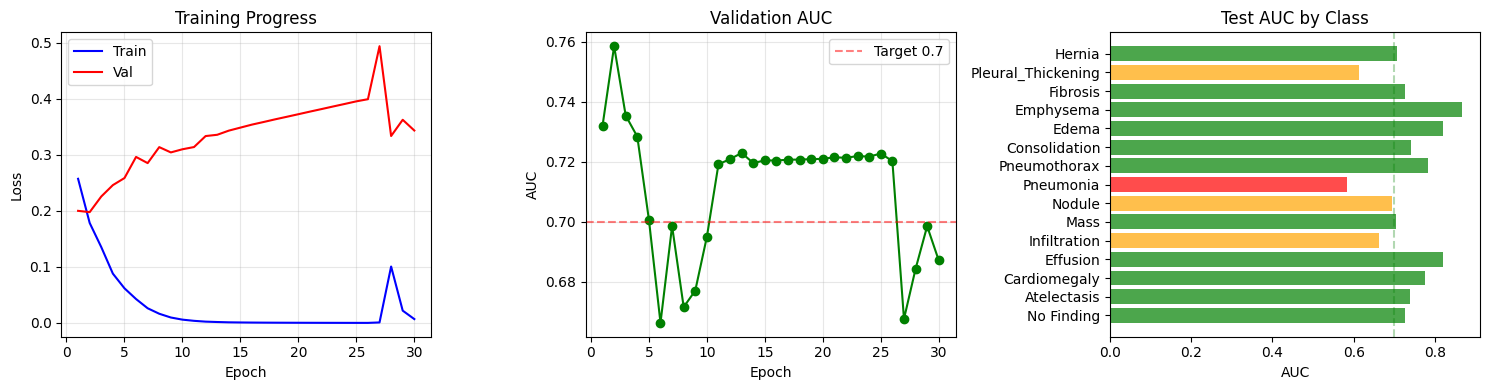

In [12]:
#%% CELL 10: PLOT RESULTS
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
ax = axes[0]
epochs_range = range(1, len(history['train_loss']) + 1)
ax.plot(epochs_range, history['train_loss'], 'b-', label='Train')
ax.plot(epochs_range, history['val_loss'], 'r-', label='Val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
ax.plot(epochs_range, history['val_auc'], 'g-', marker='o')
ax.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Target 0.7')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.set_title('Validation AUC')
ax.legend()
ax.grid(True, alpha=0.3)

# Per-class AUC
ax = axes[2]
diseases = list(metrics.keys())
aucs = [metrics[d]['AUC'] for d in diseases]
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
ax.barh(diseases, aucs, color=colors, alpha=0.7)
ax.set_xlabel('AUC')
ax.set_title('Test AUC by Class')
ax.axvline(x=0.7, color='green', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(SAVE_PATH / "results.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to: {SAVE_PATH / 'results.png'}")

In [13]:
#%% CELL 11: HOW TO LOAD MODEL
print("\n" + "="*70)
print("HOW TO LOAD THIS MODEL IN FUTURE:")
print("="*70)
print("""
# Load complete checkpoint
checkpoint = torch.load('saved_model/clarity_model_complete.pth', 
                       map_location='cpu', weights_only=False)

# Recreate model
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 15)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Access info
disease_names = checkpoint['disease_names']
test_auc = checkpoint['test_auc']
metrics = checkpoint['test_metrics']

print(f"Model loaded! Test AUC: {test_auc:.4f}")
""")

print("\n" + "="*70)
print(f"✅ TRAINING COMPLETE!")
print(f"Best Validation AUC: {best_auc:.4f}")
print(f"Test AUC: {mean_auc:.4f}")
print(f"Test F1: {mean_f1:.4f}")
print(f"All files saved in: {SAVE_PATH}")
print("="*70)


HOW TO LOAD THIS MODEL IN FUTURE:

# Load complete checkpoint
checkpoint = torch.load('saved_model/clarity_model_complete.pth', 
                       map_location='cpu', weights_only=False)

# Recreate model
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 15)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Access info
disease_names = checkpoint['disease_names']
test_auc = checkpoint['test_auc']
metrics = checkpoint['test_metrics']

print(f"Model loaded! Test AUC: {test_auc:.4f}")


✅ TRAINING COMPLETE!
Best Validation AUC: 0.7585
Test AUC: 0.7307
Test F1: 0.0752
All files saved in: saved_model
